In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.layers import *
from keras.models import *
from keras.activations import *
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import os
import itertools
import string
import tensorflow as tf
from itertools import product
import math
from utils import lex
from utils import yacc
from utils import cpp
import zipfile
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


# Here We Will Configure The Global Variables

In [ ]:
zip_name = "/content/drive/MyDrive/SLDEEP/data(10kfiles).zip"

# The collumns containing the code info
cols = ["code", "block"]
# The Archive Containing The Actual Codes
archive = zipfile.ZipFile('/content/drive/MyDrive/SLDEEP/data(10kfiles).zip', 'r')
# The first name is the name of the containing folder of the codes
list_files = archive.namelist()[1:]
# Now We will make a scanner for the C++ language
scanner = lex.lex(cpp)
# If any thing was considered fault at the line i, we will consider all the lines [i - range_n, i + range_n) to be fault
range_n = 4
# Then We Define The literals of the program
lits = cpp.literals
# Then We Define The Tokens
toks = list(cpp.tokens)
# We remove the White Space token to add it later
toks.remove("CPP_WS")
# We add the White Space token here because we want it to have the value of zero, we'll use this latter for padding lines of code
toks.insert(0, "CPP_WS")
# Tok 2 N : a dictionary from tokens to thier integer, mapped, value
tok2n = dict(zip(toks + [i for i in lits], itertools.count()))
# N 2 Tok : a dictionary from integers to thier token, mapped, value
n2tok = dict(zip(itertools.count(), toks + [i for i in lits]))

# The maximum value we allow in as a constant value in a code
max_v = 2147483647 - 1

# The amount of importance we give to 1s 0s and false postives and false negatives
WEIGHTS_FOR_LOSS = np.array([[2,0.5],[0.1,0.1]])

'''NN_MODEL = "nn"
RANDOM_FOREST_MODEL = "RF"
KNN_MODEL = "KNN"

# The type of model we will use in our work
#model_type = NN_MODEL
model_type = RANDOM_FOREST_MODEL'''


'NN_MODEL = "nn"\nRANDOM_FOREST_MODEL = "RF"\nKNN_MODEL = "KNN"\n\n# The type of model we will use in our work\n#model_type = NN_MODEL\nmodel_type = RANDOM_FOREST_MODEL'

# Here We Will Make A Custom Loss Function

In [ ]:
def get_loss_function(weights, rnn=True):

    '''
    gives us the loss function
    '''
    def w_categorical_crossentropy_mine(y_true, y_pred):
        nb_cl = len(weights)

        if(not rnn):
            final_mask = K.zeros_like(y_pred[:, 0])
            y_pred_max = K.max(y_pred, axis=1)
            y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
            y_pred_max_mat = K.equal(y_pred, y_pred_max)
            for c_p, c_t in product(range(nb_cl), range(nb_cl)):
                final_mask += ( weights[c_t, c_p] * K.cast(y_pred_max_mat, tf.float32)[:, c_p] * K.cast(y_true, tf.float32)[:, c_t]  )
            return K.categorical_crossentropy(y_true, y_pred, True) * final_mask
        else:
            final_mask = K.zeros_like(y_pred[:, :,0])
            y_pred_max = K.max(y_pred, axis=2)
            y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], K.shape(y_pred)[1], 1))
            y_pred_max_mat = K.equal(y_pred, y_pred_max)
            for c_p, c_t in product(range(nb_cl), range(nb_cl)):
                final_mask += ( weights[c_t, c_p] * K.cast(y_pred_max_mat, tf.float32)[:, :,c_p] * K.cast(y_true, tf.float32)[:, :,c_t]  )
            return K.categorical_crossentropy(y_true, y_pred, True) * final_mask


    return w_categorical_crossentropy_mine

# Reading The Data From The Archive

In [ ]:
def get_data(list_files, archive, log = False):
    '''
    reads the data and handles the range_n number
    '''
    res = []
    for i in list_files:
        try :
            x = pd.read_csv(archive.open(i), sep = "`")
            x = x[x.columns[:-1]]
            res.append(x)
        except Exception:
            print(i)
            continue
    resF = []
    for n_i, i in enumerate(res) :

        if i.shape[0] is 0 :
            continue

        a = i.values
        b = a.copy()
#         This line of code will change the data from (Features, beingWrong) to (Features, beginRight, beingWrong)
        b = np.concatenate([b[:, :-1], b[:, -1:].astype(np.int) ^ 1, b[:, -1:]], axis = -1)


        for j in range(len(b)):
            if np.sum(a[j - range_n : j + range_n, -1]) > 0 :
#                 This was explained before the declaration of range_n
                b[j, -1] = 1
                b[j, -2] = 0
        for x in range(len(b)):
            for y in range(len(b[x])):
#                 Here we will try to change any thing that is not the code it self and which is a string into numbers
                if y > 1 :
                    if type(b[x, y]) == str :
                        try :
                            float(b[x, y].strip())
                        except Exception :
                            b[x, y] = -3
                elif y == 1 :
                    b[x, y] = "DATA DOES NOT MATTER"
#         By 0s we mean the code being fine and so on
        b = pd.DataFrame(b, columns=list(i.columns)[:-1] + ["0s", "1s"])
        b.replace("#empty", np.nan, inplace =True)
        resF.append(b.dropna())

    if log :
        print("data was read and changed")
    return resF






# Lexical Scanner Function

In [ ]:
def get_replacement(scanner, string_in):

    '''
    gets a string and returns the None, 2 which is the tokenized version
    '''
    try :
        scanner.input(string_in)
    except Exception as e :
        print("Exception in using the lex", e)
        print(string_in)
    token = scanner.token()


#     id2n and n2id are the same as n2tok tok2n but they are extended to contain the information of the symbol table of each code separately
    id2n = dict(zip([i for i in lits], [tok2n[i] for i in lits]))
    n2id = dict(zip([tok2n[i] for i in lits], [i for i in lits]))

    n_id = len(lits) + 1


    res = []

    while token is not None :

        t = token.type

#         If we have recieved a token and it is not something we need to use ord for
        if t in cpp.tokens :
#             Reciving a white space
            if token.type == cpp.tokens[cpp.tokens.index("CPP_WS")]:
                #this is because this will make it easier for us to pad our data
                v = 0
#             Reciving an ID from the code
            elif token.type == cpp.tokens[cpp.tokens.index("CPP_ID")]:
                v = token.value
#                 Checking if need to add the id to n2id or not
                if v in id2n.keys() :
                    pass
                else :
                    id2n[v] = n_id
                    n2id[n_id] = v

                    n_id += 1
                v = id2n[v]
#             If we receive a string (We don't use the value of strings)
            elif token.type == cpp.tokens[cpp.tokens.index("CPP_STRING")]:
                v = -1
#             If we recive #
            elif token.type == cpp.tokens[cpp.tokens.index("CPP_POUND")]:
                v = -2
#             If we recive ##
            elif token.type == cpp.tokens[cpp.tokens.index("CPP_DPOUND")]:
                v = -3
#             If we recive char
            elif token.type == cpp.tokens[cpp.tokens.index("CPP_CHAR")]:
                v = -4
            elif token.type in cpp.tokens[3:]:
                print("some thing went really wrong")
#             Parsing the value of constant values
            else:
                try :
                    tv = token.value.lower()
                    if tv[-1] == "l" :
                        tv = tv[:-1]
                    if tv[-1] == "u" :
                        tv = tv[:-1]
                    if "x" in  tv :
                        v = int(tv, base = 16)
                    elif tv[-1].lower() == "l":
                        if tv[-2].lower() == "u" :
                            v = float(tv[:-2])
                        else :
                            v = float(tv[:-1])
                    else :
                        v = float(tv)
                    v = np.clip(v, - max_v, max_v)

                except Exception as e :
                    print("Couldn't scan this number", token)
                    return




        else :
            v = ord(t)
        try :
            t = tok2n[t]
        except Exception :
            n = len(id2n.keys()) + 1
            tok2n[t] = n
            n2tok[n] = t
            id2n[t] = n
            n2id[n] = t
            t = tok2n[t]

        res.append([t, v])
        token = scanner.token()

    res = np.array(res)

    return res





# Here We Will Tokenize Our Data Frames

In [ ]:
def tokenize_data(data):

    '''
    reads data and tokenizes each of the sentences and adds them together.
    The out put will contain the actual data, max number of lines per code and mean number of lines per code
    the actual data will have the following shape :

    Number of codes, Number of lines per each code , 2 (Data and State)
    State will contain (Code being right, Code Being Wrong)
    Data Will Contain (Number Of Words, 2 (Token, Value))

    '''

    res = []
    x = []
    mean = 0
    max_num = 0
    for i in data:
#         If We had any code submissions that was empty, we skip them
        if i.shape[0] == 0 :
            continue
        temp = []
        mean += i.shape[0]
        max_num = max(max_num, i.shape[0])

        for j in i.values :

            try :
                tok = get_replacement(scanner, j[0]).astype(np.float32)
            except Exception as e :
                continue

            x.append(tok)

            y = j[-2:]
            temp.append([tok, y])

        res.append(temp)
    mean /= len(res)

    return res, mean, max_num




# Padding The Data In The Statement Level (Adding Words)

In [ ]:
def change_cols(num, res, empty):

    '''

    pads or removes data so they all have the same shape in one code  file

    num : amount of word we'll have per each line
    empty : what we'll use to pad our data with

    '''

    resF = []

    for i in res :

        temp = []

        if (len(i) == 0):
#           We'll any coding file which is empty
            continue

        for j in i :

#             J[0] is the data and J[1] is the state

            if len(j[0]) < num :

                result = np.concatenate([j[0], np.ones(( num - len(j[0]), 2)) * empty], axis = 0)

            elif len(j[0]) > num :
                result = j[0][:num, :]
            else :
                result = j[0]

            result = result.reshape((-1))

#             This is so that we'll have the data and our state at the same time
            result = np.concatenate([result, np.array([j[1]]).reshape((-1))], axis = 0)

            temp.append(np.array(result))

        resF.append(np.array(temp))

    resF = np.array(resF)

    return resF

# Concatenating The 32 Processed Columns And Lexical Feature

In [ ]:
def get_final_data(tokenized_final, data):


    '''
    adds the information from the parser to the things that were gained from the information of scanners
    tokenized_final will be the output of "change_cols" and data will be the output of "get_data"
    '''
#     The first line reads data and drops the following columns : columns containing text of the parser or lex and the
#     The last two columns which are the state of the code which we are trying to predict
    dataR = np.concatenate([i.drop(cols, axis = 1).values[:, :-2] for i in data], axis = 0)
    dataR = dataR.astype(np.float32)

    cnt = 0

    res = []


    for i in tokenized_final :
        temp = []
        for j in i :

            add = dataR[cnt, :]
            temp.append(np.concatenate([add, j], axis = 0))

            cnt += 1


        res.append(np.array(temp))
    res = np.array(res)
    return res

# Using All The Functions Above And Normalizing Data

In [ ]:
def gather_data(list_data, archive, scaler = None, add_all = False, type_add = 0,
                pad1 = None, pad2 = None, return_before_pad = False, cons_per_line = 10, log  = False):
    '''
    Reading, Tokenizing, Concatenating And Normalizing Data
    list_data : Name Of The Codes We Are Using
    scalar : Scalar Used To Normalize Data, If None Is Presented, The Function Will Compute One
    add_all : Whether Or Not We Want All Our Codes To Have The Same Amount As For The Lines Of Code
    type_add : The amount of lines each code should contain : {0 : mean, 1 : max number of lines}
    pad1 : The amount of words each line should contain, If None is presented const_per_line + mean(amount of words per line) would be used
    pad2 : The amount of lines each code should contain, type_add would not be used if pad2 is not None
    return_before_pad : Whether or not to also return the data before it was padded to have the same amount of lines percode
    '''
#     First We Read Our Data From The Zip File
    data = get_data(list_data, archive)
#     The We tokenize our data
    r, mean, max_num = tokenize_data(data)
#     Then We Create Our Empty Vector
    empty = np.array([tok2n["CPP_WS"], 0]).reshape(1, 2).astype(np.float32)

#     The Defualt Option for Padding
    if pad1 is None :
        pad1 = int(mean) + cons_per_line

#     We Padd Our Data At Each Line With Extra White Spaces
    res = change_cols(pad1, r, empty)
    r = np.array(res)

#     Here we will concatenate our lexical features and our preprocessed features
    r = get_final_data(r, data)
    if log :
        print("Padded The Lexical And Preprocessed Features of Data")


    res = r

    if add_all :

        if log :
            print("Computing How Many Empty Line To Add To Codes ")
        if pad2 is None :

            mean = 0
            max_num = -1
            for i in r :
                mean += i.shape[0]
                max_num = max(max_num, i.shape[0])


            mean /= r.shape[0]
            nums = [int(mean), max_num]
            pad2 = nums[type_add]

        res = []
        if log :
            print("Computed How Many Empty Line To Add To Codes ")
        for i in r :

            if i.shape[0] < pad2 :

                zeros = np.zeros([pad2 - i.shape[0], i.shape[1]])
                zeros[:, -2] = 1
                temp = np.concatenate([i, zeros], axis = 0)
            elif i.shape[0] > pad2 :
                temp = i[:pad2, :]
            else :
                temp = i
            res.append(temp)
        if log :
            print("Added All The Empty Lines ")

    res = np.array(res)

    save_r = r.copy()

    r = np.concatenate(res, axis = 0).astype(np.float32)


    if scaler is None :

        scaler = StandardScaler().fit(r[:, :-2].astype(np.float32))
        if log :
            print("Computed Mean And Standard Deviation For Normalization ")

    for i, iv in enumerate(res) :

        res[i, :, :-2] = scaler.transform(iv[:, :-2].astype(np.float32)).astype(np.float32)

        if log :
            print("Data Was Normalized ")


    if return_before_pad :
        return res, scaler, pad1, pad2, save_r

    return res, scaler, pad1, pad2










In [ ]:
r_train, scaler, pad1, pad2 = gather_data(data_train, archive, add_all = True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


18

# Making The Neural Network Model

## **ACTUAL** **MODEL**

In [ ]:
def get_model(shape):


    '''
    gets the first rnn model
    shape : shape of the input : shape of the codes [Number of lines (which can be None), Number of Fetures per line]
    '''
    in1 = Input(shape)
    X = Bidirectional(LSTM(150, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(in1)
    X = LSTM(150, return_sequences=True, dropout=0.25, recurrent_dropout=0.1,)(X)
    X = Dropout(0.2)(X)
    X = Dense(256, activation=relu)(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)
    X = Dense(128, activation=relu)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.25)(X)
    X = Dense(64, activation=relu)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.3)(X)
    X = Dense(32, activation=relu)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.4)(X)
    X = Dense(16, activation=relu)(X)
    X = BatchNormalization()(X)
    X = Dropout(0.4)(X)

    X = Dense(2, activation=softmax)(X)




    model = Model(in1, X)



    return model


In [ ]:
def get_random_forest_model(shape, k):

    rf = RandomForestClassifier(n_jobs=-1)
    tuned_parameters =  {"n_estimators" : [100 * (i*2) for i in range(1, 4)],
                         "max_depth" : [2**i for i in range(5, 8)],
                         "min_samples_split" : list(np.linspace(.2, .8, 4)),
                         "min_samples_leaf" : list(np.linspace(.2, .5, 4)),
#                          "max_features" : [shape[-1] // (2**i) for i in range(1)]

                        }
    res = GridSearchCV(rf, tuned_parameters, n_jobs=-1, cv=k)

    return res


# Different Measurements For Accuracy

In [ ]:
def get_acc(y_true, y_pred):

    acc = metrics.confusion_matrix(y_true, y_pred, labels=[0, 1])
#     True Positive
    tp =  acc[1][1]
    if tp==0:
      tp+=0.0001
#     False Negative
    fn =  acc[1][0]
    if fn==0:
      fn+=0.0001
#     False Positive
    fp =  acc[0][1]
    if fp==0:
      fp+=0.0001
#     True Negative
    tn =  acc[0][0]
    if tn==0:
      tn+=0.0001
#     Recall
    rec1 = acc[1][1] / (acc[1][1] + acc[1][0])
#     Precision
    prec1 = acc[1][1] / (acc[1][1] + acc[0][1])
#     Over ALl Accuracy
    accuracy = (acc[1][1] + acc[0][0]) / (acc[1][1] + acc[0][0] + acc[1][0] + acc[0][1])
#     F1 Accuracy
    f1 = 2.0 / ((1.0/rec1) + (1.0/prec1))

    return rec1, prec1, accuracy, f1 , tp , fn , fp , tn



# Pre-Paring Data For Measurements

In [ ]:
def get_mus(y_true, x, model):


    y_t = np.argmax(y_true, axis = -1).reshape((-1))
    y_p = model.predict(x)
    y_p = np.argmax(y_p, axis=-1).reshape((-1))



    return get_acc(y_t, y_p)




In [ ]:
def get_mus(y_true, x, model):

    global model_type

    if model_type == NN_MODEL:
        y_t = np.argmax(y_true, axis = -1).reshape((-1))
        y_p = model.predict(x)
        y_p = np.argmax(y_p, axis=-1).reshape((-1))
    else :
        y_t = y_true
        y_p = model.predict(x)


    return get_acc(y_t, y_p)


In [ ]:
model_type

'RF'

# Using All The Defined Functions  

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# K is for our K-fold
k = 10
# The name of the codes we want to use, you can slice this list to a smaller list for a fast test
l = list_files[:]
print(l)
print("l:",len(l))
# The number of codes we use on each fold
size = math.ceil(len(l) / k)
print("size:",size)
# Verbose for our NN model
verbose = 1

# The results for trains and tests respectivly
trs = []
ts = []

for i in range(k):

    print("k", i)
#     start and end will be the indicies for what we'll use for test
    start  = i * size
    #start=0
    end    = min(len(l), (i + 1) * size)
    #end=2000

    print("start:",start)
    print("end:",end)

    data_train = l[:start] + l[end:]
    data_test  = l[start : end]
    print("train data:",len(data_train))
    print("test data:",len(data_test))
    if len(data_test) <= 0 or len(data_train) <= 0 :
        print("hey")
        continue

    # gathering data for train
    r_train, scaler, pad1, pad2 = gather_data(data_train, archive, add_all = True)
    # gathering data for test, please note that the same mean and standard deviation that was computed for train will be used to
    # normalize test data and also the information of pad1 and pad2 is computed from train so that no information will be
    # leaked from train and also none of the aforementioned are dependent on the test data
    r_test, _, _, _ = gather_data(data_test, archive, scaler = scaler, add_all = True, pad1 = pad1, pad2 = pad2)

    print("data read")

    # configuring model
    model = get_model([None, r_train.shape[-1] - 2])
    #loss = get_loss_function(WEIGHTS_FOR_LOSS)
    model.compile(tf.keras.optimizers.Adam(learning_rate=5e-4),loss=keras.losses.categorical_crossentropy, metrics = ["accuracy"])


    # making the X, y for train and test set
    X_train = r_train[:, :, :-2]
    y_train = r_train[:, :, -2:]


    X_test = r_test[:, :, :-2]
    y_test = r_test[:, :, -2:]
    #print("X_train_data:",X_train)
    #print("X_test_data:",X_test)
    print("X_train:",len(X_train))
    print("y_train:",len(y_train))
    print("X_test:",len(X_test))
    print("y_test:",len(y_test))

     #convert to tensor
    X_train=np.asarray(X_train).astype('float32')
    y_train=np.asarray(y_train).astype('float32')
    X_test=np.asarray(X_test).astype('float32')
    y_test=np.asarray(y_test).astype('float32')

    # training the model
    print("training on the data started ")
    hist=model.fit(X_train, y_train, validation_data = [X_test, y_test], epochs = 15, batch_size = 16, verbose = verbose, shuffle=True)
    print("training on the data finished ")
    #model.save(filepath='final_weight(10kfiles(k5)_20ep).h5')
    # saving and printing the accuracy of training data
    print("train : rec1, prec1, accuracy, f1, acc , tp , fn , fp , tn ")
    trs.append(get_mus(y_train, X_train,model))
    print(trs[-1])

    # preparing to write the training accuracy to a file
    strRes = "train : "
    for counter in range(8):
        strRes = strRes + '%.5f' % trs[-1][counter] + " , "

    strRes += " \n "


    # saving and printing the accuracy of testing data
    print("test : rec1, prec1, accuracy, f1, acc, tp , fn , fp , tn ")
    ts.append(get_mus(y_test, X_test,model))
    print(ts[-1])

    # preparing to write the testing accuracy to a file
    strRes += " test :  "
    for counter in range(8):
        strRes = strRes + '%.5f' % ts[-1][counter] + " , "

    # writing the accuracies on to a file
    f = open("test.txt", "a")
    f.write(strRes + "\n")
    f.close()


['data/1012353.cpp.csv', 'data/1014829.cpp.csv', 'data/1014872.cpp.csv', 'data/1015374.cpp.csv', 'data/1017046.cpp.csv', 'data/1026376.cpp.csv', 'data/1026421.cpp.csv', 'data/1026802.cpp.csv', 'data/1030900.cpp.csv', 'data/1041474.cpp.csv', 'data/1041803.cpp.csv', 'data/1043440.cpp.csv', 'data/1043506.cpp.csv', 'data/1043511.cpp.csv', 'data/1046247.cpp.csv', 'data/1046623.cpp.csv', 'data/1046653.cpp.csv', 'data/1049264.cpp.csv', 'data/1049521.cpp.csv', 'data/1070671.cpp.csv', 'data/1074458.cpp.csv', 'data/1074649.cpp.csv', 'data/1074650.cpp.csv', 'data/1074664.cpp.csv', 'data/1074667.cpp.csv', 'data/1074671.cpp.csv', 'data/1074684.cpp.csv', 'data/1074686.cpp.csv', 'data/1074688.cpp.csv', 'data/1075077.cpp.csv', 'data/1084122.cpp.csv', 'data/1115803.cpp.csv', 'data/1117053.cpp.csv', 'data/1117508.cpp.csv', 'data/1121268.cpp.csv', 'data/1124150.cpp.csv', 'data/1124367.cpp.csv', 'data/1124384.cpp.csv', 'data/1124848.cpp.csv', 'data/1124919.cpp.csv', 'data/1128833.cpp.csv', 'data/1128983.c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 58s 89ms/step - loss: 0.5190 - accuracy: 0.8018 - val_loss: 0.3560 - val_accuracy: 0.8515
Epoch 2/15
563/563 [==============================] - 50s 88ms/step - loss: 0.3779 - accuracy: 0.8575 - val_loss: 0.3115 - val_accuracy: 0.8698
Epoch 3/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3493 - accuracy: 0.8728 - val_loss: 0.2926 - val_accuracy: 0.8832
Epoch 4/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3452 - accuracy: 0.8778 - val_loss: 0.2883 - val_accuracy: 0.8857
Epoch 5/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3424 - accuracy: 0.8801 - val_loss: 0.3534 - val_accuracy: 0.8602
Epoch 6/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3540 - accuracy: 0.8717 - val_loss: 0.2825 - val_accuracy: 0.8896
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 59s 91ms/step - loss: 0.5487 - accuracy: 0.7899 - val_loss: 0.3485 - val_accuracy: 0.8761
Epoch 2/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3741 - accuracy: 0.8593 - val_loss: 0.3073 - val_accuracy: 0.8830
Epoch 3/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3591 - accuracy: 0.8736 - val_loss: 0.3319 - val_accuracy: 0.8976
Epoch 4/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3639 - accuracy: 0.8765 - val_loss: 0.3909 - val_accuracy: 0.8993
Epoch 5/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3678 - accuracy: 0.8795 - val_loss: 0.3346 - val_accuracy: 0.8838
Epoch 6/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3666 - accuracy: 0.8804 - val_loss: 0.3572 - val_accuracy: 0.9134
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 59s 92ms/step - loss: 0.5865 - accuracy: 0.7507 - val_loss: 0.3599 - val_accuracy: 0.8666
Epoch 2/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3563 - accuracy: 0.8618 - val_loss: 0.3238 - val_accuracy: 0.8804
Epoch 3/15
563/563 [==============================] - 50s 90ms/step - loss: 0.3008 - accuracy: 0.8847 - val_loss: 0.2694 - val_accuracy: 0.8905
Epoch 4/15
563/563 [==============================] - 50s 89ms/step - loss: 0.2726 - accuracy: 0.8984 - val_loss: 0.2396 - val_accuracy: 0.9093
Epoch 5/15
563/563 [==============================] - 51s 91ms/step - loss: 0.2435 - accuracy: 0.9139 - val_loss: 0.2606 - val_accuracy: 0.9092
Epoch 6/15
563/563 [==============================] - 51s 90ms/step - loss: 0.2235 - accuracy: 0.9244 - val_loss: 0.2401 - val_accuracy: 0.9120
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 60s 92ms/step - loss: 0.5343 - accuracy: 0.7730 - val_loss: 0.3662 - val_accuracy: 0.8582
Epoch 2/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3718 - accuracy: 0.8573 - val_loss: 0.2727 - val_accuracy: 0.8921
Epoch 3/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3299 - accuracy: 0.8792 - val_loss: 0.3271 - val_accuracy: 0.8921
Epoch 4/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3576 - accuracy: 0.8794 - val_loss: 0.3551 - val_accuracy: 0.9132
Epoch 5/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3703 - accuracy: 0.8786 - val_loss: 0.3788 - val_accuracy: 0.9112
Epoch 6/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3662 - accuracy: 0.8811 - val_loss: 0.2957 - val_accuracy: 0.8878
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 59s 92ms/step - loss: 0.5457 - accuracy: 0.7670 - val_loss: 0.3119 - val_accuracy: 0.8627
Epoch 2/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3674 - accuracy: 0.8603 - val_loss: 0.2598 - val_accuracy: 0.9037
Epoch 3/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3612 - accuracy: 0.8689 - val_loss: 0.2697 - val_accuracy: 0.9089
Epoch 4/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3730 - accuracy: 0.8807 - val_loss: 0.3124 - val_accuracy: 0.8866
Epoch 5/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3908 - accuracy: 0.8784 - val_loss: 0.2998 - val_accuracy: 0.8815
Epoch 6/15
563/563 [==============================] - 50s 90ms/step - loss: 0.4124 - accuracy: 0.8722 - val_loss: 0.4413 - val_accuracy: 0.8723
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 59s 91ms/step - loss: 0.5319 - accuracy: 0.7798 - val_loss: 0.3290 - val_accuracy: 0.8878
Epoch 2/15
563/563 [==============================] - 50s 89ms/step - loss: 0.3997 - accuracy: 0.8557 - val_loss: 0.3417 - val_accuracy: 0.8952
Epoch 3/15
563/563 [==============================] - 51s 91ms/step - loss: 0.3838 - accuracy: 0.8641 - val_loss: 0.3376 - val_accuracy: 0.9079
Epoch 4/15
563/563 [==============================] - 51s 90ms/step - loss: 0.3768 - accuracy: 0.8717 - val_loss: 0.2766 - val_accuracy: 0.9087
Epoch 5/15
563/563 [==============================] - 50s 90ms/step - loss: 0.3891 - accuracy: 0.8674 - val_loss: 0.3398 - val_accuracy: 0.9109
Epoch 6/15
563/563 [==============================] - 50s 90ms/step - loss: 0.3990 - accuracy: 0.8634 - val_loss: 0.3365 - val_accuracy: 0.8938
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 63s 96ms/step - loss: 0.5354 - accuracy: 0.7889 - val_loss: 0.3253 - val_accuracy: 0.8764
Epoch 2/15
563/563 [==============================] - 53s 95ms/step - loss: 0.3630 - accuracy: 0.8599 - val_loss: 0.2812 - val_accuracy: 0.8937
Epoch 3/15
563/563 [==============================] - 54s 95ms/step - loss: 0.3340 - accuracy: 0.8733 - val_loss: 0.2878 - val_accuracy: 0.9046
Epoch 4/15
563/563 [==============================] - 54s 95ms/step - loss: 0.3233 - accuracy: 0.8843 - val_loss: 0.2283 - val_accuracy: 0.9152
Epoch 5/15
563/563 [==============================] - 53s 95ms/step - loss: 0.3121 - accuracy: 0.8942 - val_loss: 0.2459 - val_accuracy: 0.9096
Epoch 6/15
563/563 [==============================] - 53s 95ms/step - loss: 0.3157 - accuracy: 0.8918 - val_loss: 0.2479 - val_accuracy: 0.9151
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 63s 96ms/step - loss: 0.5223 - accuracy: 0.7644 - val_loss: 0.3472 - val_accuracy: 0.8646
Epoch 2/15
563/563 [==============================] - 53s 94ms/step - loss: 0.3722 - accuracy: 0.8613 - val_loss: 0.2771 - val_accuracy: 0.8980
Epoch 3/15
563/563 [==============================] - 53s 94ms/step - loss: 0.3451 - accuracy: 0.8747 - val_loss: 0.2605 - val_accuracy: 0.8992
Epoch 4/15
563/563 [==============================] - 54s 96ms/step - loss: 0.3266 - accuracy: 0.8833 - val_loss: 0.2425 - val_accuracy: 0.9082
Epoch 5/15
563/563 [==============================] - 54s 96ms/step - loss: 0.3241 - accuracy: 0.8849 - val_loss: 0.2973 - val_accuracy: 0.8758
Epoch 6/15
563/563 [==============================] - 53s 95ms/step - loss: 0.3230 - accuracy: 0.8847 - val_loss: 0.2454 - val_accuracy: 0.9122
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 8999
y_train: 8999
X_test: 1000
y_test: 1000
training on the data started 
Epoch 1/15
563/563 [==============================] - 64s 98ms/step - loss: 0.5414 - accuracy: 0.7741 - val_loss: 0.3653 - val_accuracy: 0.8855
Epoch 2/15
563/563 [==============================] - 54s 95ms/step - loss: 0.3932 - accuracy: 0.8562 - val_loss: 0.3200 - val_accuracy: 0.8949
Epoch 3/15
563/563 [==============================] - 53s 94ms/step - loss: 0.3818 - accuracy: 0.8652 - val_loss: 0.3094 - val_accuracy: 0.8946
Epoch 4/15
563/563 [==============================] - 53s 95ms/step - loss: 0.3635 - accuracy: 0.8712 - val_loss: 0.3043 - val_accuracy: 0.9052
Epoch 5/15
563/563 [==============================] - 54s 95ms/step - loss: 0.3644 - accuracy: 0.8730 - val_loss: 0.4070 - val_accuracy: 0.8956
Epoch 6/15
563/563 [==============================] - 53s 95ms/step - loss: 0.3777 - accuracy: 0.8734 - val_loss: 0.4523 - val_accuracy: 0.8986
Epoch 7/15
563/563 [======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data read
X_train: 9000
y_train: 9000
X_test: 999
y_test: 999
training on the data started 
Epoch 1/15
563/563 [==============================] - 63s 97ms/step - loss: 0.5468 - accuracy: 0.7682 - val_loss: 0.3955 - val_accuracy: 0.8516
Epoch 2/15
563/563 [==============================] - 53s 94ms/step - loss: 0.3782 - accuracy: 0.8533 - val_loss: 0.2512 - val_accuracy: 0.9105
Epoch 3/15
563/563 [==============================] - 53s 95ms/step - loss: 0.3647 - accuracy: 0.8700 - val_loss: 0.3474 - val_accuracy: 0.8775
Epoch 4/15
563/563 [==============================] - 54s 96ms/step - loss: 0.4066 - accuracy: 0.8766 - val_loss: 0.3300 - val_accuracy: 0.8967
Epoch 5/15
563/563 [==============================] - 55s 98ms/step - loss: 0.4167 - accuracy: 0.8783 - val_loss: 0.3390 - val_accuracy: 0.9086
Epoch 6/15
563/563 [==============================] - 59s 105ms/step - loss: 0.4259 - accuracy: 0.8763 - val_loss: 0.4044 - val_accuracy: 0.8944
Epoch 7/15
563/563 [=======================

In [ ]:
model.save('lstm_weights.h5')

In [ ]:
trs = np.array(trs)
ts = np.array(ts)
print("avg train : rec1, prec1, accuracy, f1")
train_avg=np.mean(trs[:, : 4], axis=0)
#print(np.mean(trs[:, : 4], axis=0))
print(train_avg)
print("avg test : rec1, prec1, accuracy, f1")
test_avg=np.mean(ts[:, : 4], axis=0)
#print(np.mean(ts[:, : 4], axis=0))
print(test_avg)

avg train : rec1, prec1, accuracy, f1
[0.57284051 0.91465165 0.88110575 0.67254504]
avg test : rec1, prec1, accuracy, f1
[0.53018131 0.86887935 0.85925599 0.62153045]


In [ ]:
train_res=train_avg
test_res=test_avg



In [ ]:
names=['rec1', 'prec1', 'accuracy', 'f1']
dict_pd={'names':['rec1', 'prec1', 'accuracy', 'f1'],'train_res':train_res,'test_res':test_res}
data=pd.DataFrame(dict_pd)
data

,names,train_res,test_res
0,rec1,0.572841,0.530181
1,prec1,0.914652,0.868879
2,accuracy,0.881106,0.859256
3,f1,0.672545,0.621530


In [ ]:
data.to_csv("ten_fold_avg_result.csv")

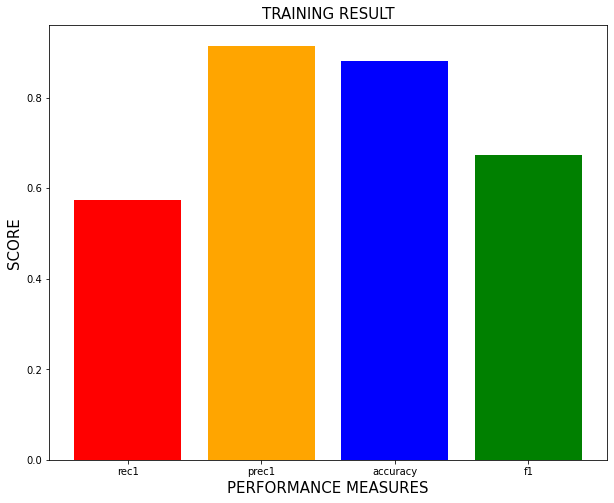

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))

colors={'rec1':'red', 'prec1':'orange', 'accuracy':'blue', 'f1':'green'}
c=data['names'].apply(lambda x:colors[x])
plt.bar(dict_pd['names'], dict_pd['train_res'], color=c)
#plt.legend(['recall','precision','accuracy','f-measure'])
plt.title("TRAINING RESULT", fontsize=15)
plt.xlabel('PERFORMANCE MEASURES', fontsize=15)
plt.ylabel('SCORE', fontsize=15)
plt.show()


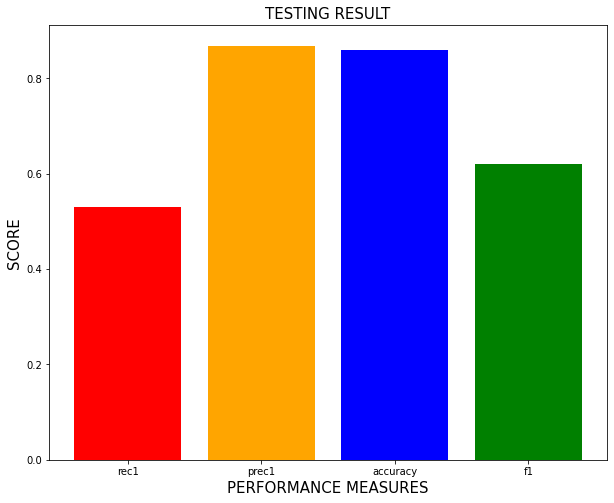

In [ ]:
plt.figure(figsize=(10,8))
colors={'rec1':'red', 'prec1':'orange', 'accuracy':'blue', 'f1':'green'}
c=data['names'].apply(lambda x:colors[x])
plt.bar(dict_pd['names'], dict_pd['test_res'], color=c)
#plt.legend(['recall','precision','accuracy','f-measure'], loc='upper left')
plt.title("TESTING RESULT",fontsize=15)
plt.xlabel('PERFORMANCE MEASURES',fontsize=15)
plt.ylabel('SCORE',fontsize=15)
plt.show()

In [ ]:
keras.models.load_model('/content/final_weight(10kfiles(k10)_20ep).h5')
model.load_weights

<bound method Model.load_weights of <keras.engine.functional.Functional object at 0x7f10d2d8d210>>

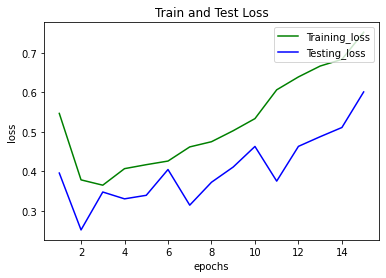

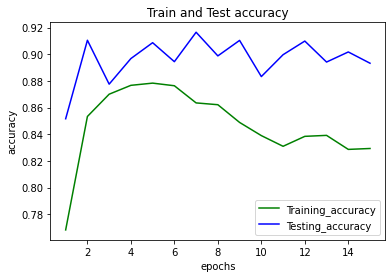

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs, loss, 'g')
plt.plot(epochs, val_loss, 'b')
plt.legend(labels=['Training_loss', 'Testing_loss'], loc='upper right')
plt.title('Train and Test Loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure(2)
acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
epochs=range(1,len(loss)+1)
plt.plot(epochs, acc, 'g')
plt.plot(epochs, val_acc, 'b')
plt.legend(labels=['Training_accuracy', 'Testing_accuracy'], loc='lower right')
plt.title('Train and Test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')



plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [ ]:
y_pred_lstm=model.predict(X_test)[:,1]

In [ ]:
y_pred_lstm

array([[0.88139015, 0.11860983],
       [0.88467556, 0.11532443],
       [0.88530844, 0.11469156],
       ...,
       [0.8852407 , 0.11475936],
       [0.8825561 , 0.11744396],
       [0.88291097, 0.11708896]], dtype=float32)

In [ ]:
y=np.where(y_pred_lstm>0.5,1,0)

array([1, 0])

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)